In [376]:
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objects as go
import statistics
pd.set_option('max_columns',1000)

In [228]:
# Reading defender wise passing attributes dataset
defender_attrs = pd.read_pickle('../data/defender_clustering_dataset.pkl')

In [229]:
# Filtering out left center backs from this dataset for both 4 at the back and non 4 at the back formations
defender_attrs_lcb = defender_attrs.loc[(defender_attrs['position']=='LCB') | (defender_attrs['position']=='L_CB')]

In [230]:
defender_attrs_lcb.head()

,player_name,team,position,footedness,passes,accpass,accpassloc,inaccpassloc,accpassvaep,inaccpassvaep,accpassoff,inaccpassoff,accpassdef,inaccpassdef,matches_played
1,AaronCresswell,West Ham,LCB,left,796,644,"[[[27.04, 51.68], [55.12, 64.6]], [[65.52, 61....","[[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...","[0.0010694738011807203, 0.002371369395405054, ...","[-0.00956201646476984, -0.007710381411015987, ...","[0.0018120664171874523, 0.002711281180381775, ...","[-0.006647953763604164, -0.006097717210650444,...","[-0.0007425926742143929, -0.000339911784976720...","[-0.002914062701165676, -0.001612664433196187,...",20.0
7,AdrianMariappa,Watford,L_CB,right,179,144,"[[[36.4, 45.56], [74.88, 48.28]], [[30.16, 46....","[[[43.68, 20.4], [42.64, 26.52]], [[27.04, 59....","[0.007817169651389122, 0.014505142346024513, -...","[-0.012487044557929039, -0.014621571637690067,...","[0.006556161679327488, 0.014376532286405563, -...","[0.0002851502504199743, 0.0005775007884949446,...","[0.0012610082048922777, 0.0001286100596189499,...","[-0.012772195041179657, -0.015199072659015656,...",5.0
12,AhmedHegazi,West Brom,LCB,right,108,85,"[[[30.16, 59.84], [8.32, 52.36]], [[13.52, 45....","[[[38.48, 63.24], [67.6, 62.56]], [[32.24, 57....","[-0.0006447772029787302, 0.005508015863597393,...","[-0.0023842889349907637, -0.000174969201907515...","[-0.0004856684245169163, 0.0003083648625761270...","[-0.0002966243773698807, 0.0005698907189071178...","[-0.00015910877846181393, 0.00519965123385191,...","[-0.002087664557620883, -0.0007448599208146334...",3.0
13,AhmedHegazi,West Brom,L_CB,right,438,347,"[[[31.2, 44.88], [41.6, 44.2]], [[46.8, 48.96]...","[[[41.6, 57.12], [70.72, 56.44]], [[27.04, 52....","[0.0017347207758575678, 0.0011076731607317924,...","[-0.003586119506508112, -0.0061787767335772514...","[0.0009571132250130177, 9.425170719623566e-05,...","[-0.0005135340616106987, -0.000820334302261471...","[0.0007776075508445501, 0.0010134214535355568,...","[-0.0030725854448974133, -0.005358442664146423...",16.0
21,AlfieMawson,Swansea,LCB,right,758,620,"[[[22.88, 47.6], [28.08, 57.12]], [[42.64, 63....","[[[6.24, 65.28], [3.12, 66.64]], [[28.08, 60.5...","[0.038905542343854904, -0.00048424117267131805...","[-0.0028287151362746954, -0.004615758545696735...","[0.0026092270854860544, 0.0003214506432414055,...","[-0.000753563828766346, -0.0015460746362805367...","[0.03629631549119949, -0.0008056918159127235, ...","[-0.0020751513075083494, -0.003069684142246842...",19.0


In [231]:
# Function to get start and end location points for every row in df
def getstartend(locs):
    end_points = list()
    start_points = list()
    for point in locs:
            if point != []:
                end_points.append(point[1])
                start_points.append(point[0])
    return start_points,end_points

In [232]:
# Function to segregate progressive passes for every row of pass location column
def distfilter(locs,vaeps):
    loc_start, loc_end = getstartend(locs)
    progpass = 0
    prog_passlocs = list()
    prog_passvaeps = list()
    for p1,p2,vaep in zip(loc_start,loc_end,vaeps):
        dist = np.round(np.linalg.norm(np.array(p1) - np.array(p2)),2)
        if p1[0] < 52 and dist >= 30 and p1[0] < p2[0]:
            prog_passlocs.append([np.round(p1,2),np.round(p2,2)])
            prog_passvaeps.append(vaep)
        elif p1[0] > 52 and dist >= 10 and p1[0] < p2[0]:
            prog_passlocs.append([np.round(p1,2),np.round(p2,2)])
            prog_passvaeps.append(vaep)
    progpass = len(prog_passlocs)
    return pd.Series([prog_passlocs,prog_passvaeps,progpass])
            

In [233]:
defender_attrs_lcb[['progaccpassloc','progaccpassvaep','progaccpass']] = defender_attrs_lcb.apply(lambda x: distfilter(x['accpassloc'],x['accpassvaep']), axis = 1)

/Users/shreygrover/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [234]:
defender_attrs_lcb[['proginaccpassloc','proginaccpassvaep','proginaccpass']] = defender_attrs_lcb.apply(lambda x: distfilter(x['inaccpassloc'],x['inaccpassvaep']),axis=1)

In [235]:
defender_attrs_lcb.reset_index(inplace = True)

In [236]:
len(defender_attrs_lcb)

98

In [237]:
# Dropping defenders who have zero progressive passes
defender_attrs_lcb = defender_attrs_lcb.loc[defender_attrs_lcb['progaccpass']!=0]

In [238]:
# Counting the total number of accurate progressive passes and accurate progressive vaep values for left center backs
counter_accprog = 0
counter_accprog_vaep = 0
for index, row in defender_attrs_lcb.iterrows():
    counter_accprog = counter_accprog + len(row['progaccpassloc'])
    counter_accprog_vaep = counter_accprog_vaep + len(row['progaccpassvaep'])

In [239]:
# Counting the total number of inaccurate progressive passes and inaccurate progressive vaep values for left center backs
counter_inaccprog = 0
counter_inaccprog_vaep = 0
for index, row in defender_attrs_lcb.iterrows():
    counter_inaccprog = counter_inaccprog + len(row['proginaccpassloc'])
    counter_inaccprog_vaep = counter_inaccprog_vaep + len(row['proginaccpassvaep'])

In [240]:
counter_accprog, counter_accprog_vaep

(6864, 6864)

In [241]:
counter_inaccprog, counter_inaccprog_vaep

(2314, 2314)

In [242]:
np.sum(defender_attrs_lcb['progaccpass'].tolist())

6864

In [243]:
np.sum(defender_attrs_lcb['proginaccpass'].tolist())

2314

In [244]:
defender_attrs_lcb.head()

,index,player_name,team,position,footedness,passes,accpass,accpassloc,inaccpassloc,accpassvaep,inaccpassvaep,accpassoff,inaccpassoff,accpassdef,inaccpassdef,matches_played,progaccpassloc,progaccpassvaep,progaccpass,proginaccpassloc,proginaccpassvaep,proginaccpass
0,1,AaronCresswell,West Ham,LCB,left,796,644,"[[[27.04, 51.68], [55.12, 64.6]], [[65.52, 61....","[[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...","[0.0010694738011807203, 0.002371369395405054, ...","[-0.00956201646476984, -0.007710381411015987, ...","[0.0018120664171874523, 0.002711281180381775, ...","[-0.006647953763604164, -0.006097717210650444,...","[-0.0007425926742143929, -0.000339911784976720...","[-0.002914062701165676, -0.001612664433196187,...",20.0,"[[[27.04, 51.68], [55.12, 64.6]], [[61.36, 59....","[0.0010694738011807203, 0.002284318208694458, ...",184,"[[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...","[-0.00956201646476984, -0.007710381411015987, ...",91
1,7,AdrianMariappa,Watford,L_CB,right,179,144,"[[[36.4, 45.56], [74.88, 48.28]], [[30.16, 46....","[[[43.68, 20.4], [42.64, 26.52]], [[27.04, 59....","[0.007817169651389122, 0.014505142346024513, -...","[-0.012487044557929039, -0.014621571637690067,...","[0.006556161679327488, 0.014376532286405563, -...","[0.0002851502504199743, 0.0005775007884949446,...","[0.0012610082048922777, 0.0001286100596189499,...","[-0.012772195041179657, -0.015199072659015656,...",5.0,"[[[36.4, 45.56], [74.88, 48.28]], [[30.16, 46....","[0.007817169651389122, 0.014505142346024513, 0...",29,"[[[74.88, 48.28], [95.68, 63.92]], [[43.68, 58...","[-0.018855780363082886, -0.0001047381665557622...",17
2,12,AhmedHegazi,West Brom,LCB,right,108,85,"[[[30.16, 59.84], [8.32, 52.36]], [[13.52, 45....","[[[38.48, 63.24], [67.6, 62.56]], [[32.24, 57....","[-0.0006447772029787302, 0.005508015863597393,...","[-0.0023842889349907637, -0.000174969201907515...","[-0.0004856684245169163, 0.0003083648625761270...","[-0.0002966243773698807, 0.0005698907189071178...","[-0.00015910877846181393, 0.00519965123385191,...","[-0.002087664557620883, -0.0007448599208146334...",3.0,"[[[9.36, 49.64], [46.8, 35.36]], [[59.28, 60.5...","[0.005519402213394642, 0.014088563621044159, 0...",25,"[[[32.24, 57.8], [94.64, 8.84]], [[37.44, 55.7...","[-0.00017496920190751553, -0.00290540279820561...",14
3,13,AhmedHegazi,West Brom,L_CB,right,438,347,"[[[31.2, 44.88], [41.6, 44.2]], [[46.8, 48.96]...","[[[41.6, 57.12], [70.72, 56.44]], [[27.04, 52....","[0.0017347207758575678, 0.0011076731607317924,...","[-0.003586119506508112, -0.0061787767335772514...","[0.0009571132250130177, 9.425170719623566e-05,...","[-0.0005135340616106987, -0.000820334302261471...","[0.0007776075508445501, 0.0010134214535355568,...","[-0.0030725854448974133, -0.005358442664146423...",16.0,"[[[35.36, 38.08], [43.68, 5.44]], [[33.28, 38....","[0.001253026886843145, 0.007582114078104496, 0...",72,"[[[30.16, 6.12], [69.68, 20.4]], [[87.36, 60.5...","[0.0008075747173279524, -0.011176194064319134,...",46
4,21,AlfieMawson,Swansea,LCB,right,758,620,"[[[22.88, 47.6], [28.08, 57.12]], [[42.64, 63....","[[[6.24, 65.28], [3.12, 66.64]], [[28.08, 60.5...","[0.038905542343854904, -0.00048424117267131805...","[-0.0028287151362746954, -0.004615758545696735...","[0.0026092270854860544, 0.0003214506432414055,...","[-0.000753563828766346, -0.0015460746362805367...","[0.03629631549119949, -0.0008056918159127235, ...","[-0.0020751513075083494, -0.003069684142246842...",19.0,"[[[35.36, 51.68], [74.88, 15.64]], [[64.48, 52...","[0.009057893417775631, 0.009907348081469536, 0...",150,"[[[27.04, 58.48], [76.96, 68.0]], [[34.32, 42....","[-0.0029905715491622686, 0.0004464306402951479...",74


In [245]:
def_cols = defender_attrs_lcb.columns
len(def_cols)

22

In [246]:
new_def_cols = ['index','player_name','team','position','footedness','matches_played','passes','accpass','progaccpass','proginaccpass',
                'accpassloc','inaccpassloc','progaccpassloc','proginaccpassloc','accpassvaep','inaccpassvaep','progaccpassvaep','proginaccpassvaep',
                'accpassoff','inaccpassoff','accpassdef','inaccpassdef']
print(len(new_def_cols))
defender_attrs_lcb = defender_attrs_lcb[new_def_cols]

22


In [247]:
# Saving dataframe in data folder
defender_attrs_lcb.to_pickle('../data/defender_clusters/defender_attrs_lcb_prog.pkl')

In [248]:
defender_attrs_lcb.loc[defender_attrs_lcb['proginaccpass']==0]

,index,player_name,team,position,footedness,matches_played,passes,accpass,progaccpass,proginaccpass,accpassloc,inaccpassloc,progaccpassloc,proginaccpassloc,accpassvaep,inaccpassvaep,progaccpassvaep,proginaccpassvaep,accpassoff,inaccpassoff,accpassdef,inaccpassdef
84,328,SebastianProdl,Watford,L_CB,right,1.0,23,20,4,0,"[[[33.28, 42.16], [46.8, 51.68]], [[30.16, 37....","[[[33.28, 12.24], [33.28, 10.2]], [[44.72, 31....","[[[31.2, 38.76], [40.56, 9.52]], [[29.12, 45.5...",[],"[0.0012551185209304094, -0.001588225713931024,...","[-0.008191711269319057, -0.005829870700836182,...","[0.0012825950980186462, 0.007226516958326101, ...",[],"[0.0013731876388192177, -0.0008652694523334503...","[-0.0013740502763539553, -0.003711424069479108...","[-0.00011806911788880825, -0.00072295626159757...","[-0.006817661225795746, -0.00211844639852643, ..."
91,363,VincentKompany,Man City,L_CB,right,1.0,81,81,10,0,"[[[28.08, 38.76], [29.12, 18.36]], [[31.2, 45....",[],"[[[33.28, 49.64], [68.64, 47.6]], [[53.04, 44....",[],"[0.00015552854165434837, 0.004266505129635334,...",[],"[0.010318076238036156, 0.003410935401916504, 0...",[],"[0.000225903932005167, 0.004114686977118254, 0...",[],"[-7.037539035081863e-05, 0.0001518179196864366...",[]


In [249]:
# Function to get x and y coordinates of pass locations
def getxy(locs):
    x = list()
    y = list()
    for p in locs:
        x.append(p[0])
        y.append(p[1])
    return x,y

In [250]:
# Function to calcuate total value added by passes in each of the following regions:
#  ( x - length of the pitch) (y - width of the pitch)
# Right Flank Attack - x >= 52 and y <= 17
# Right Flank Defence - x < 52 and y <= 17
# Right Central Attack - x >= 52 and y > 17 and y <= 34
# Right Central Defence - x < 52 and y > 17 and y <= 34
# Left Central Attack - x >= 52 and y > 34 and y <= 51
# Left Central Defence - x < 52 and y > 34 and y <= 51
# Left Flank Attack - x >= 52 and y > 51 and y <= 68
# Left Flank Defence - x < 52 and y > 51 and y <= 68
def get_vaep_region(x,y,vaep):
    vaep_rightflank_attack, vaep_rightflank_defence, vaep_rightcentral_attack, vaep_rightcentral_defence, vaep_leftcentral_attack, vaep_leftcentral_defence, vaep_leftflank_attack, vaep_leftflank_defence= 0,0,0,0,0,0,0,0
    if vaep!= []:
        vaep_rightflank_attack = np.sum([vaep[i] for i in range(len(x)) if (x[i]>=52) and (y[i]<=17)])
        vaep_rightflank_defence = np.sum([vaep[i] for i in range(len(x)) if (x[i]<52) and (y[i]<=17)])
        vaep_rightcentral_attack = np.sum([vaep[i] for i in range(len(x)) if (x[i]>=52) and (y[i]>17) and (y[i]<=34)])
        vaep_rightcentral_defence = np.sum([vaep[i] for i in range(len(x)) if (x[i]<52) and (y[i]>17) and (y[i]<=34)])
        vaep_leftcentral_attack = np.sum([vaep[i] for i in range(len(x)) if (x[i]>=52) and (y[i]>34) and (y[i]<=51)])
        vaep_leftcentral_defence = np.sum([vaep[i] for i in range(len(x)) if (x[i]<52) and (y[i]>34) and (y[i]<=51)])
        vaep_leftflank_attack = np.sum([vaep[i] for i in range(len(x)) if (x[i]>=52) and (y[i]>51) and (y[i]<=68)])
        vaep_leftflank_defence = np.sum([vaep[i] for i in range(len(x)) if (x[i]<52) and (y[i]>51) and (y[i]<=68)])
    
    return [vaep_leftflank_defence,vaep_leftcentral_defence,vaep_rightcentral_defence,vaep_rightflank_defence,vaep_leftflank_attack,vaep_leftcentral_attack,vaep_rightcentral_attack,vaep_rightflank_attack]

In [319]:
# Function to get total number of progressive pass made in each of the following regions:
#  ( x - length of the pitch) (y - width of the pitch)
# Right Flank Attack - x >= 52 and y <= 17
# Right Flank Defence - x < 52 and y <= 17
# Right Central Attack - x >= 52 and y > 17 and y <= 34
# Right Central Defence - x < 52 and y > 17 and y <= 34
# Left Central Attack - x >= 52 and y > 34 and y <= 51
# Left Central Defence - x < 52 and y > 34 and y <= 51
# Left Flank Attack - x >= 52 and y > 51 and y <= 68
# Left Flank Defence - x < 52 and y > 51 and y <= 68
def get_pass_region(x,y):
    x_rightflank_attack, x_rightflank_def, x_leftflank_attack, x_leftflank_def, x_rightcentral_attack, x_rightcentral_def, x_leftcentral_attack, x_leftcentral_def = list(),list(),list(),list(),list(),list(),list(),list()
    if x!=[]:
        x_rightflank_attack = [
            x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)]
        y_rightflank_attack = [
            y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)]
        x_rightflank_def = [
            x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)]
        y_rightflank_def = [
            y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)]
        x_leftflank_attack = [
            x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)]
        y_leftflank_attack = [
            y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)]
        x_leftflank_def = [
            x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)]
        y_leftflank_def = [
            y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)]
        x_rightcentral_attack = [
            x[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)]
        y_rightcentral_attack = [
            y[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)]
        x_rightcentral_def = [
            x[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)]
        y_rightcentral_def = [
            y[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)]
        x_leftcentral_attack = [
            x[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)]
        y_leftcentral_attack = [
            y[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)]
        x_leftcentral_def = [
            x[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)]
        y_leftcentral_def = [
            y[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)]
    return [len(x_leftflank_def), len(x_leftcentral_def),
        len(x_rightcentral_def), len(x_rightflank_def), 
        len(x_leftflank_attack), len(x_leftcentral_attack), 
        len(x_rightcentral_attack), len(x_rightflank_attack)]

In [320]:
# Function to calculate progressive passes per region and vaep value per region
# Note: vaep value is divided by the number of progresssive passes and scaled to 1000 to make the value significant
def get_region_wise(locs,vaep):
    locs_start, locs_end = getstartend(locs)
    locs_x, locs_y = getxy(locs_end)
    vaep_region = get_vaep_region(locs_x,locs_y,vaep)
    prog_region = get_pass_region(locs_x,locs_y)
    vaep_region_per_pass = list()
    print(vaep_region)
    print(prog_region)
    prog_region_per_pass = list()
    if prog_region !=[]:
        for i,j in zip(vaep_region,prog_region):
            if j == 0:
                vaep_region_per_pass.append(0)
                prog_region_per_pass.append(j)
            else:
                vaep_region_per_pass.append((i/j)*1000)
                prog_region_per_pass.append(np.round(j/len(locs_x)*100,2))
    else:
        vaep_region_per_pass = list()
        prog_region_per_pass = list()
    return pd.Series([prog_region_per_pass,vaep_region_per_pass])

**Comparing Perference with Accuracy over a defender in each region**

In [298]:
defender_attrs_lcb[['prog_acc_region_per_pass','vaep_acc_region_per_pass']] = defender_attrs_lcb.apply(lambda x: get_region_wise(x['progaccpassloc'],x['progaccpassvaep']), axis = 1)

In [299]:
defender_attrs_lcb[['prog_inacc_region_per_pass','vaep_inacc_region_per_pass']] = defender_attrs_lcb.apply(lambda x: get_region_wise(x['proginaccpassloc'],x['proginaccpassvaep']), axis = 1)

In [344]:
# Function to get preference (i.e. what percentage of progressive passes does the player make in each region) and 
# accuracy (i.e. what is the accuracy of making progressive passes in each region)
def get_preference_accuracy(progaccpassloc,proginaccpassloc):
    progpasses = list(progaccpassloc) + list(proginaccpassloc)
    progpasses_start, progpasses_end = getstartend(progpasses)
    progaccpass_start, progaccpass_end = getstartend(progaccpassloc)
#     proginaccpass_start, proginaccpass_end = getstartend(proginaccpassloc)
    prog_locs_x, prog_locs_y = getxy(progpasses_end)
    progaccpass_locs_x, progaccpass_locs_y = getxy(progaccpass_end)
#     proginaccpass_locs_x, proginaccpass_locs_y = getxy(proginaccpass_end)
    prog_region = get_pass_region(prog_locs_x,prog_locs_y)
    progacc_pass_region = get_pass_region(progaccpass_locs_x,progaccpass_locs_y)
    proginacc_pass_region = [prog_region[i] - progacc_pass_region[i] for i in range(8)]
    progpreference_per_region = list()
    progaccuracy_per_region = list()
    if prog_region!=[]:
        for i in range(8):
            if prog_region[i]!=0:
                progpreference_per_region.append(np.round((prog_region[i]/len(prog_locs_x))*100,2))
                progaccuracy_per_region.append(np.round((progacc_pass_region[i]/prog_region[i])*100,2))
            else:
                progpreference_per_region.append(np.round((prog_region[i]/len(prog_locs_x))*100,2))
                progaccuracy_per_region.append(0)
    else:
        progpreference_per_region = list()
        progaccuracy_per_region = list()
    return pd.Series([progpreference_per_region,progaccuracy_per_region])
    

In [345]:
defender_attrs_lcb[['progpreference_per_region','progaccuracy_per_region']] = defender_attrs_lcb.apply(lambda x: get_preference_accuracy(x['progaccpassloc'],x['proginaccpassloc']),axis = 1)

In [372]:
defender_attrs_lcb_plot_prefacc = defender_attrs_lcb.loc[(defender_attrs_lcb['progaccpass'] + defender_attrs_lcb['proginaccpass'])>=10]

In [390]:
def plot_preference_accuracy_region(df):
    regions = ['leftflank_def','leftcentral_def',
           'rightcentral_def','rightflank_def',
           'leftflank_attack','leftcentral_attack',
           'rightcentral_attack','rightflank_attack']
    for i in range(8):
        prog_region = list()
        acc_region =list()
        player_name_position = list()
        for idx, row in df.iterrows():
                prog_region.append(row['progpreference_per_region'][i])
                acc_region.append(row['progaccuracy_per_region'][i])
                player_name_position.append(row['player_name'] + " " + row['position'] + " " + row['footedness'])
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = prog_region, y = acc_region, text = player_name_position, name = 'Plot' + str(i), mode = 'markers'))
        fig.update_layout(
            shapes = [dict(
                  type= 'line',
                  yref= 'y', y0= 0, y1= 100,
                  xref= 'x', x0= statistics.median(prog_region), x1= statistics.median(prog_region),
                  line=dict(
                  color="Red",
                  width=4,
                  dash="dashdot")),
                    dict(
                  type= 'line',
                  yref= 'y', y0= statistics.median(acc_region), y1= statistics.median(acc_region),
                  xref= 'x', x0= 0, x1= max(prog_region),
                  line=dict(
                  color="Red",
                  width=4,
                  dash="dashdot"))                     
                    ])
        fig.update_layout(
            annotations=[
                dict(
                x=0.5,
                y=-0.15,
                showarrow=False,
                text = '% Progressive Pass',
                xref="paper",
                yref="paper"),
                dict(
                x=-0.07,
                y=0.5,
                showarrow = False,
                text = '% Progressive Pass Accuracy',
                textangle = -90,
                xref="paper",
                yref="paper")
            ])
        fig.update_layout(
            autosize=True,
            margin=dict(
            b=100
            ),
            title_text = str(regions[i]))
        fig.show()

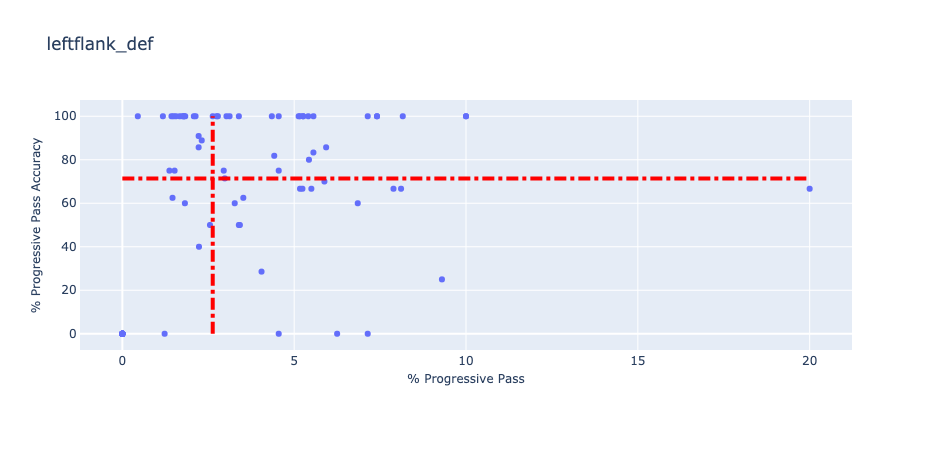

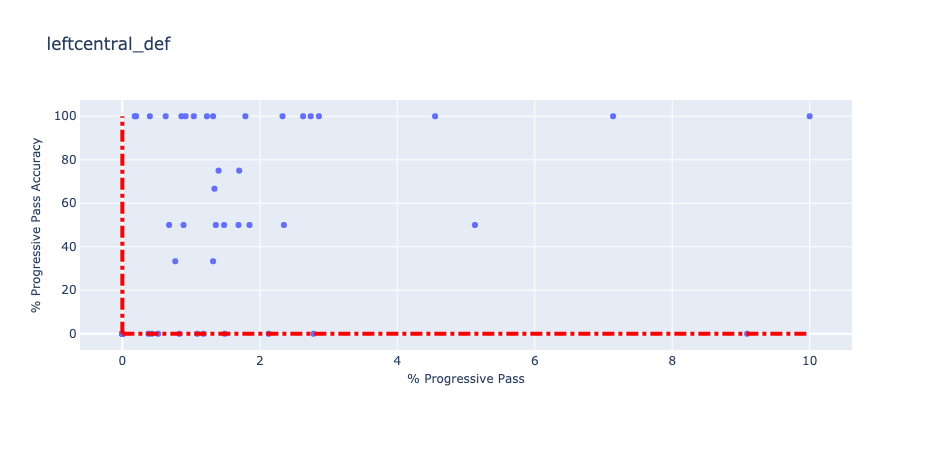

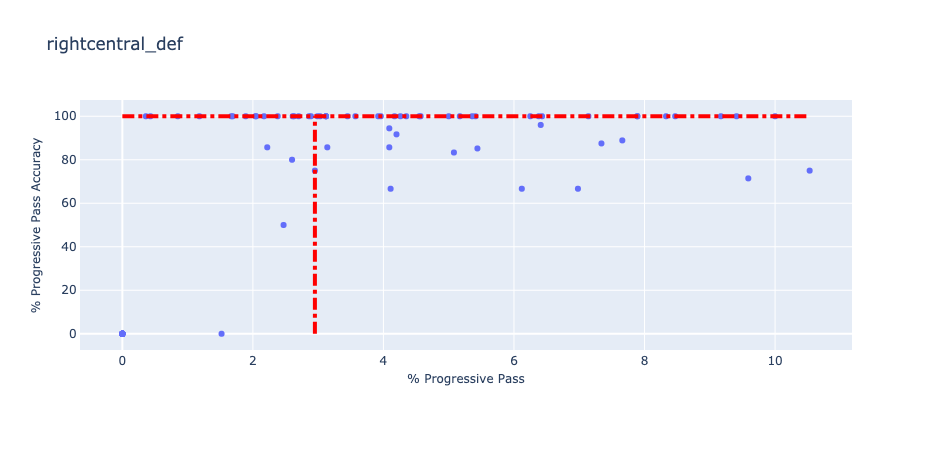

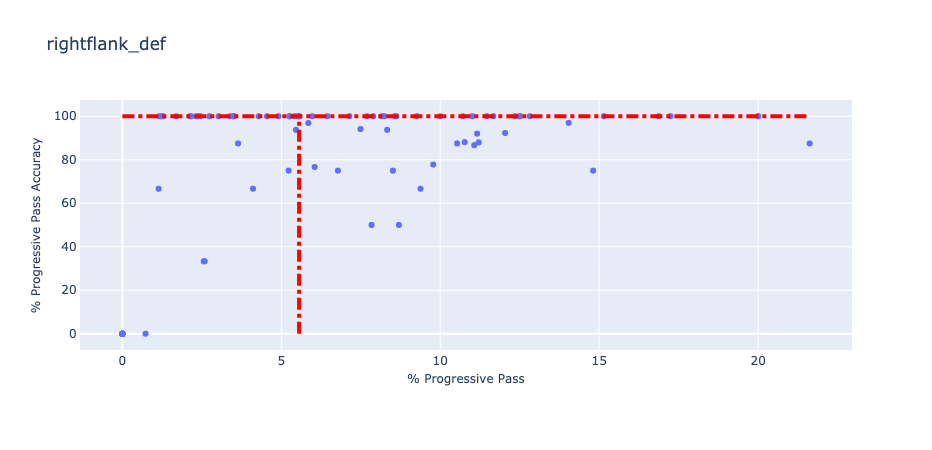

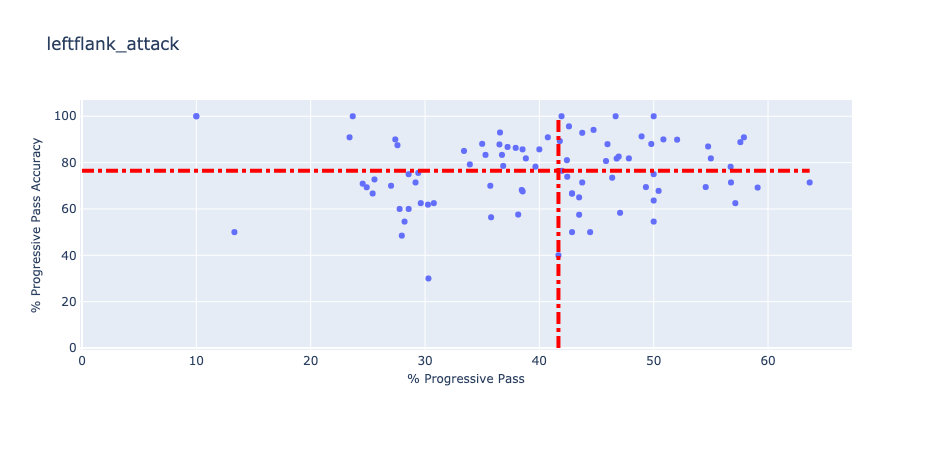

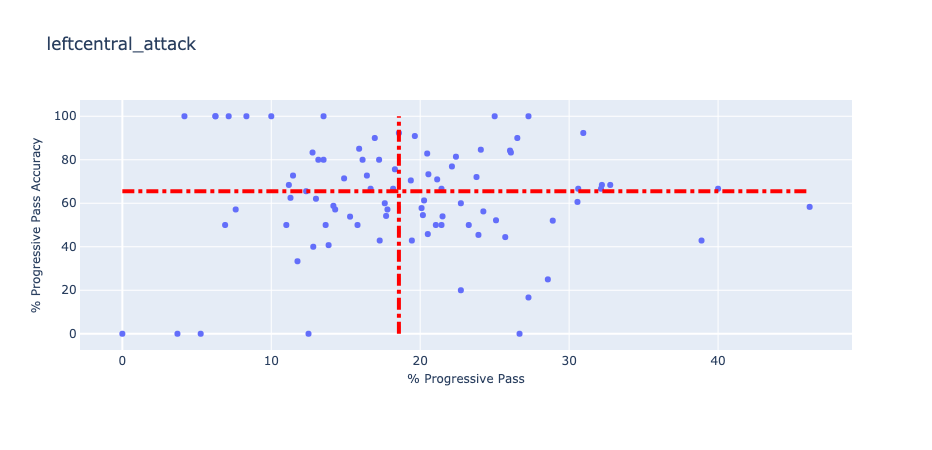

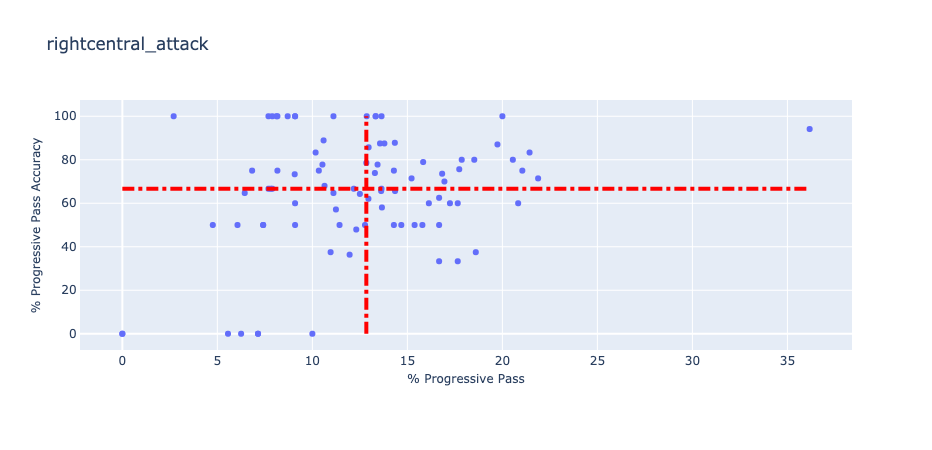

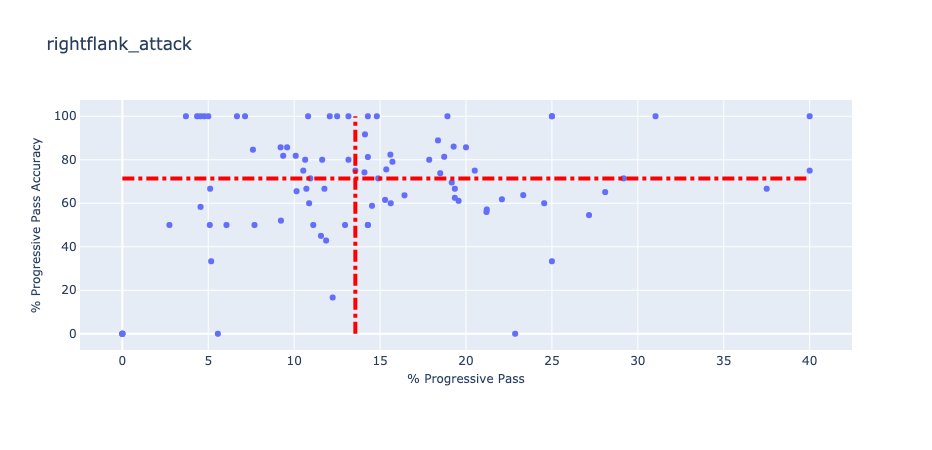

In [391]:
plot_preference_accuracy_region(defender_attrs_lcb_plot_prefacc)

In [362]:
# defender_attrs_lcb.loc[defender_attrs_lcb['player_name'].str.contains('Musta')]

In [363]:
# defender_attrs_lcb.loc[defender_attrs_lcb['player_name'].str.contains('Aaron')]

In [364]:
# get_region_wise(defender_attrs_lcb['proginaccpassloc'][75],defender_attrs_lcb['proginaccpassvaep'][75])

In [365]:
# Saving the region wise pass and vaep dataframe
defender_attrs_lcb.to_pickle('../data/defender_clusters/defender_attrs_lcb_region_wise.pkl')

In [284]:
# len(defender_attrs_lcb)

95

In [285]:
# len(defender_attrs_lcb.loc[defender_attrs_lcb['matches_played']>=10])

31

In [287]:
# len(defender_attrs_lcb.loc[(defender_attrs_lcb['progaccpass'] + defender_attrs_lcb['proginaccpass']>=20)])

74

**Plotting value added in every region for accurate passes**

In [366]:
defender_attrs_lcb = pd.read_pickle('../data/defender_clusters/defender_attrs_lcb_region_wise.pkl')

In [367]:
defender_attrs_lcb_plot = defender_attrs_lcb[['player_name','team','position','footedness','matches_played',
                                              'progaccpass','proginaccpass','prog_acc_region_per_pass',
                                              'vaep_acc_region_per_pass','prog_inacc_region_per_pass',
                                              'vaep_inacc_region_per_pass']]

In [368]:
defender_attrs_lcb_plot = defender_attrs_lcb_plot.loc[defender_attrs_lcb_plot['progaccpass'] + defender_attrs_lcb['proginaccpass']>=20]

In [369]:
player_names = list(zip(defender_attrs_lcb_plot['player_name'].tolist(),defender_attrs_lcb_plot['position'].tolist()))
player_names

[('AaronCresswell', 'LCB'),
 ('AdrianMariappa', 'L_CB'),
 ('AhmedHegazi', 'LCB'),
 ('AhmedHegazi', 'L_CB'),
 ('AlfieMawson', 'LCB'),
 ('AlfieMawson', 'L_CB'),
 ('AngeloOgbonna', 'LCB'),
 ('AngeloOgbonna', 'L_CB'),
 ('AntonioRudiger', 'LCB'),
 ('AshleyWilliams', 'L_CB'),
 ('AymericLaporte', 'L_CB'),
 ('BenMee', 'L_CB'),
 ('BrunoMartinsIndi', 'LCB'),
 ('BrunoMartinsIndi', 'L_CB'),
 ('CalumChambers', 'L_CB'),
 ('ChrisSmalling', 'L_CB'),
 ('ChristianKabasele', 'LCB'),
 ('ChristianKabasele', 'L_CB'),
 ('ChristopherSchindler', 'L_CB'),
 ('CiaranClark', 'LCB'),
 ('CiaranClark', 'L_CB'),
 ('DeclanRice', 'LCB'),
 ('DejanLovren', 'L_CB'),
 ('EliaquimMangala', 'L_CB'),
 ('ErikPieters', 'LCB'),
 ('FlorianLejeune', 'L_CB'),
 ('GaryCahill', 'LCB'),
 ('GeoffCameron', 'LCB'),
 ('HarryMaguire', 'L_CB'),
 ('JamesCollins', 'LCB'),
 ('JamesTarkowski', 'L_CB'),
 ('JamesTomkins', 'L_CB'),
 ('JanVertonghen', 'LCB'),
 ('JanVertonghen', 'L_CB'),
 ('JonnyEvans', 'LCB'),
 ('JonnyEvans', 'L_CB'),
 ('JoseHolebas',

In [370]:
# Function to plot scatter plots for preference over value addition across regions
# Arguments : 
# prog_region -  A list of proggressive pasess per region (in percentage)
# veap_region - A list of vaep values per region (scaled by 10000)
# att_def - 'Attack' for attacking region and 'Defence' for defensive region
def plot_preference_value_region(df,result_type='acc'):
    regions = ['leftflank_def','leftcentral_def',
           'rightcentral_def','rightflank_def',
           'leftflank_attack','leftcentral_attack',
           'rightcentral_attack','rightflank_attack']
    for i in range(8):
        prog_region = list()
        vaep_region =list()
        player_name_position = list()
        if result_type == 'acc':
            for idx, row in df.iterrows():
                prog_region.append(row['prog_acc_region_per_pass'][i])
                vaep_region.append(row['vaep_acc_region_per_pass'][i])
                player_name_position.append(row['player_name'] + " " + row['position'] + " " + row['footedness'])
        elif result_type == 'inacc':
            for idx, row in df.iterrows():
                prog_region.append(row['prog_inacc_region_per_pass'][i])
                vaep_region.append(row['vaep_inacc_region_per_pass'][i])
                player_name_position.append(row['player_name'] + " " + row['position'] + " " + row['footedness'])
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = prog_region, y = vaep_region, text = player_name_position, name = 'Plot' + str(i), mode = 'markers'))
        fig.update_layout(
            annotations=[
                dict(
                x=0.5,
                y=-0.15,
                showarrow=False,
                text = '% Progressive passes',
                xref="paper",
                yref="paper"),
                dict(
                x=-0.07,
                y=0.5,
                showarrow = False,
                text = 'VAEP per progressive pass (scaled to 10000)',
                textangle = -90,
                xref="paper",
                yref="paper")
            ],
            autosize=True,
            margin=dict(
            b=100
            ),
            title_text = str(regions[i]))
        fig.show()

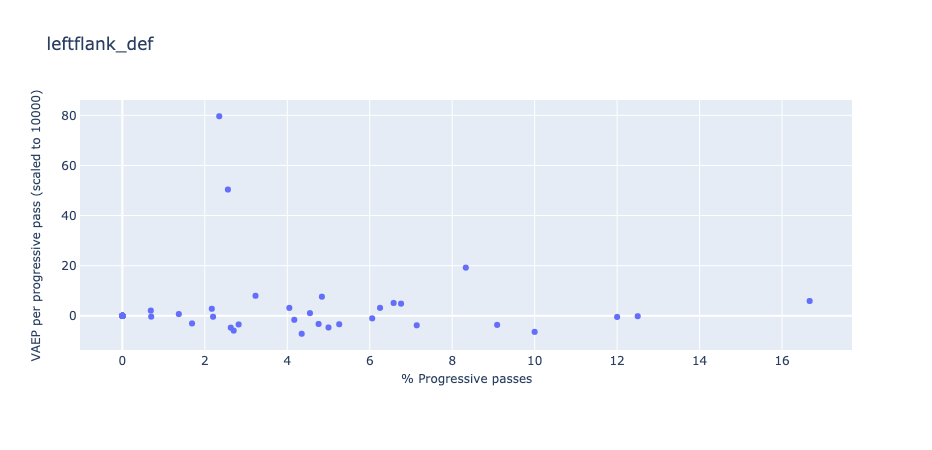

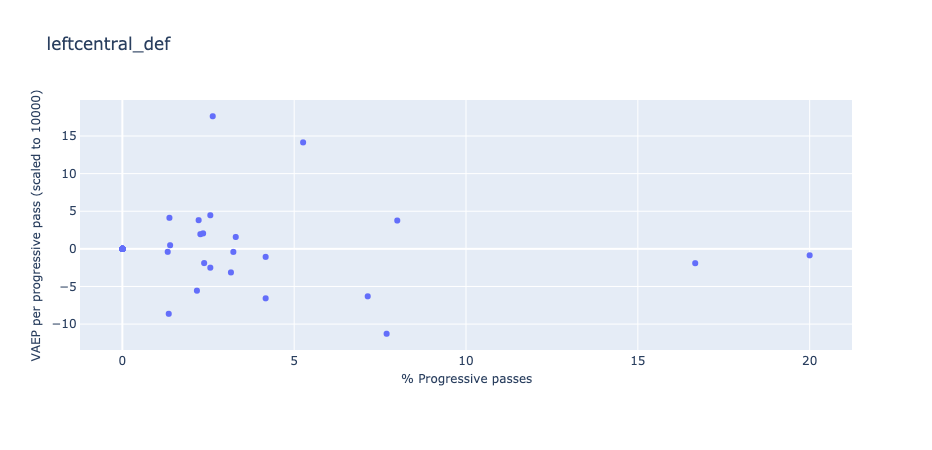

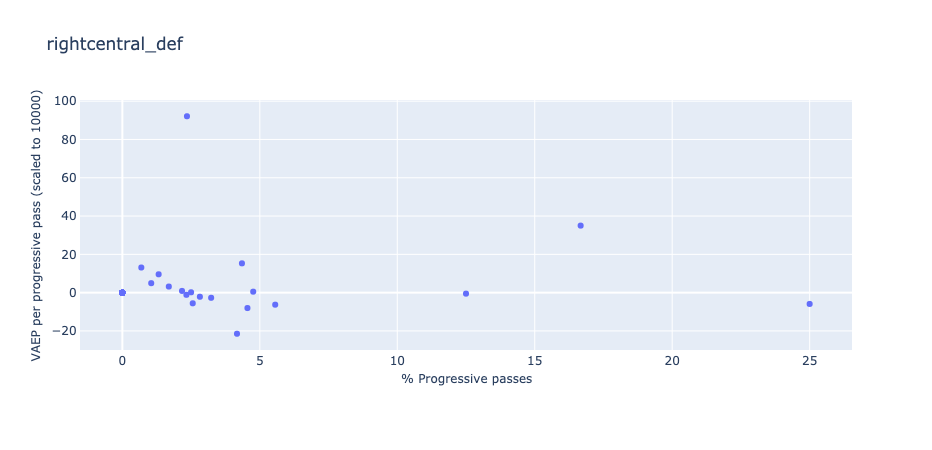

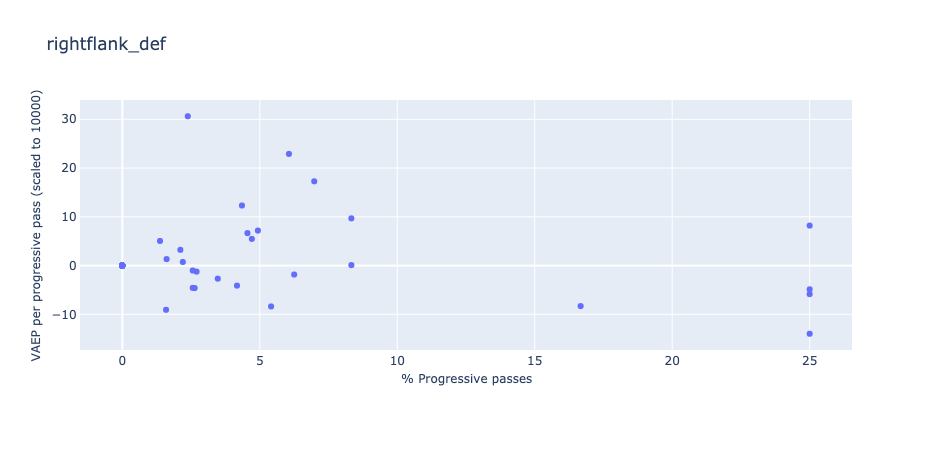

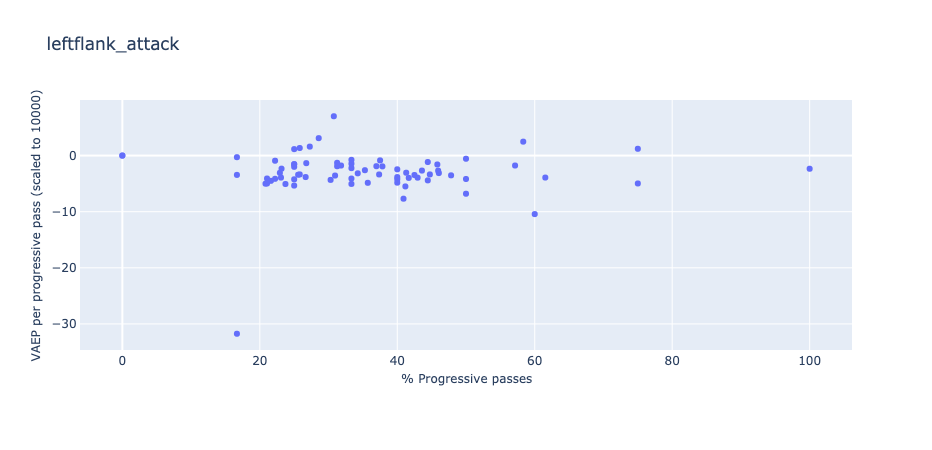

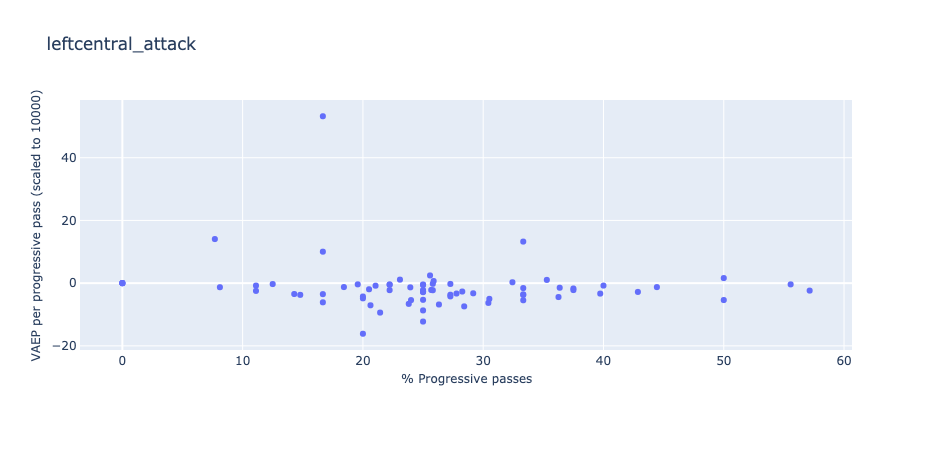

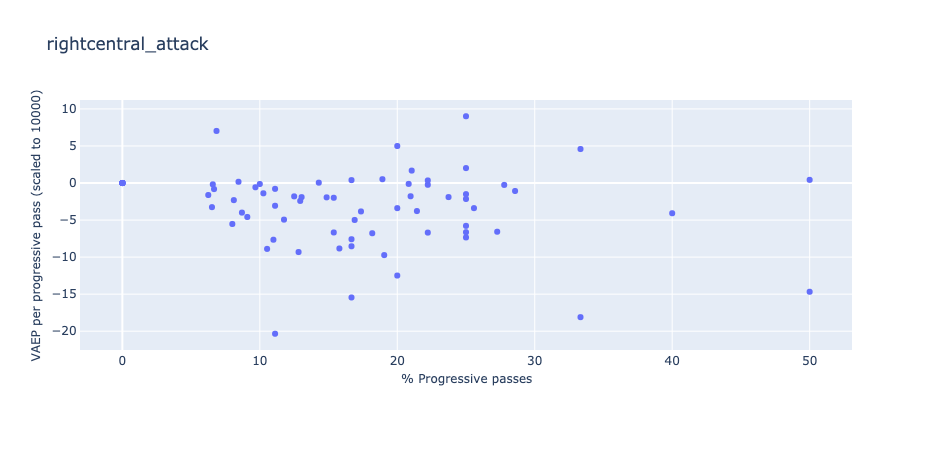

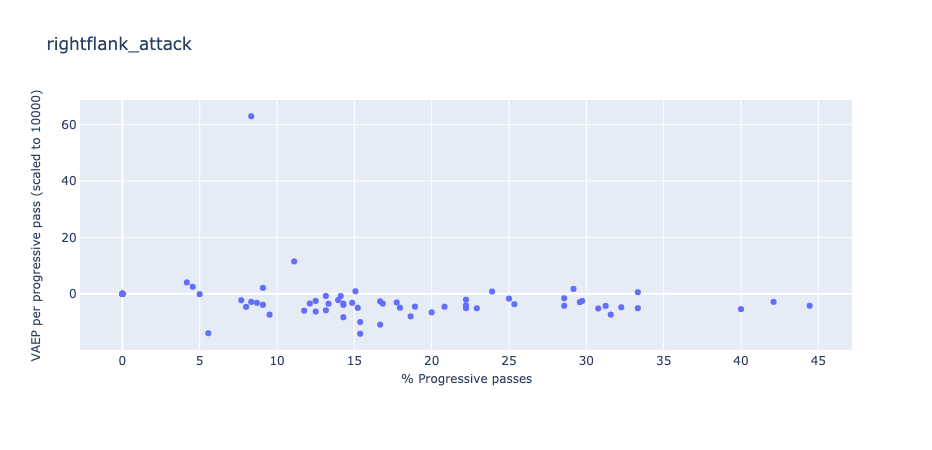

In [371]:
plot_preference_value_region(defender_attrs_lcb_plot, result_type = 'inacc')